Something has to be wrong with what plastid is doing here, the total counts for ribosome profiling reads from that table are greater then the total number of counts for the original data itself! The whole thing seems... backwards. And the RNA seq counts from the table are like, 30 times smaller than the one from the dataset?

# Calculating Gene expression. 

This script calculates gene expression in raw read counts, RPKM and TPM (So we are looking at the raw reads and a normalizsed measure of gene expression) using matched samples of RNA-seq and ribosome profiling data. 


Gene expression – or, more broadly, read density over from any high-throughput sequencing experiment over any genomic region – can be calculated easily in an interactive Python session.

Here I am caclulating read density over coding regions.

## Importing packages and defining the path

In [3]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [4]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [10]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/mmus/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/mmus/"
gtf_name = 'mm10.refGene.gtf'
RPF_name = 'control_RPF_2'
RNA_name = 'control_RNA_2'

## Loading in the data

Open the read alignments, storing each dataset in a BAMGenomeArray:

In [6]:
my_datasets = { "ribosome_profiling" : data_path + RPF_name + "_Aligned.sortedByCoord.out.bam",
                "RNA-seq"            : data_path + RNA_name + "_Aligned.sortedByCoord.out.bam",
              }

my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

Next, we tell the BAMGenomeArrays which mapping rule to use. We will use a custom built function to apply 3' end mapping to the ribosomal p-site. 

In [8]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + RPF_name + "_Aligned.toTranscriptome.out_p-site-offsets", sep="\t")

# Map the ribosome profiling alignments to the p-site. 
my_datasets["ribosome_profiling"].set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

We will map the RNA-seq data along the entire length of each read alignment. Each position in each alignment will be attributed 1.0/ℓ, where ℓ is the length of the read alignment. CenterMapFactory() can do this for us:

"Figure out exactly what this is doing"

In [9]:
my_datasets["RNA-seq"].set_mapping(CenterMapFactory())

Let's quickly load up our genome annotation data as a list of plastid transcript objects.

In [11]:
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

Now, we need to create a place to hold our data. We’ll use dictionary of lists. The call to copy.deepcopy() on the empty list is necessary to prevent all of these dictionary keys from pointing to the same list, which is a weird side effect of the order in which things are evaluated inside comprehensions:

Once we have created an empty dictionary of lists to hold our data, we’re ready to start calculating are measurements of transcript expression. We’ll use nested for loops to count expression of each transcript. Note that the code below takes about 1 hour to run. 

In [15]:
gtf_reads[1].attr

{'gene_name': 'Rp1',
 'score': '.',
 'source': 'refGene',
 'gene_id': 'Rp1',
 'transcript_id': 'NM_001370921',
 'cds_genome_end': 4352825,
 'cds_genome_start': 4120003,
 'type': 'mRNA'}

In [16]:
# we will count gene sub-regions in addition to entire genes
region = ("CDS")

# we will calculate both total counts and RPKM
metrics = ("counts","rpk","lengths")

# create an empty list for each sample, region, and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs
my_data["transcript_ID"] = []
my_data["gene_ID"] = []

for transcript in gtf_reads:
        
    # First, save ID of transcript we are evaluating
    my_data["transcript_ID"].append(transcript.get_name())
    my_data["gene_ID"].append(transcript.attr["gene_name"])

    # Iterate over each sample, getting the counts over each region
    for sample_name, sample_data in my_datasets.items():
        # transcript.get_counts() fetches a list of counts at each position
        # here we just want the sum
        counts = sum(transcript.get_counts(sample_data))
        rpk   = float(counts)/(transcript.length/1000)
        lengths = transcript.length
        #rpkm   = float(counts) / transcript.length * 1000 * 1e6 / sample_data.sum()
        my_data["%s_counts" % (sample_name)].append(counts)
        my_data["%s_rpk"   % (sample_name)].append(rpk)
        my_data["%s_lengths" % (sample_name)].append(lengths)
        #my_data["%s_rpkm"   % (sample_name)].append(rpkm)

In [17]:
# convert to Dataframe
df = pd.DataFrame(my_data)

# Estimating and plotting translation efficiency
Translation efficiency is a measurement of how much protein is made from a single mRNA. Translation efficiency thus reports specifically on the translational control of gene expression.

Translation efficiency can be estimated by normalizing an mRNA’s translating ribosome density (in TPM, as measured by ribosome profiling) by the mRNA’s abundance (in TPM, measured by RNA-Seq) ([IGNW09]).

Making this estimate from the calculations above is simple:

In [18]:
# Calculate tpm using rpk from our new dataframe. 
for sample_name, sample_data in my_datasets.items():
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s
    
# Calculate rpkm using the read counts. Work in progress.
for sample_name, sample_data in my_datasets.items():
    counts = df["%s_counts"   % (sample_name)]
    rpkm   = counts / df["%s_lengths"   % (sample_name)]*1000 * 1e6 / sum(counts)
    df["%s_rpkm" % (sample_name)] = rpkm
    
    
# Calculate translation efficiency using tpm
df["TE_tpm"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

# Calculate translation efficiency using rpkm
df["TE_rpkm"] = df["ribosome_profiling_rpkm"] / df["RNA-seq_rpkm"]

In [19]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', "gene_ID", 'TE_tpm','TE_rpkm','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk', 'ribosome_profiling_lengths', 'RNA-seq_lengths']
df = df[cols]

In [20]:
df.to_csv(save_path + "control_2_te_table.csv", index=False)

In [22]:
#!# A line of code that quickly loads up the data if it has already been saved. 
df = pd.read_csv(save_path + "control_2_te_table.csv")

In [28]:
df

,transcript_ID,gene_ID,TE_tpm,TE_rpkm,ribosome_profiling_tpm,RNA-seq_tpm,ribosome_profiling_counts,RNA-seq_counts,ribosome_profiling_rpkm,RNA-seq_rpkm,ribosome_profiling_rpk,RNA-seq_rpk,ribosome_profiling_lengths,RNA-seq_lengths
0,NM_001011874,Xkr4,1.229482,1.258248,10.004512,8.137179,196.0,6.383243,3.856895,3.065289,53.935058,1.756534,3634,3634
1,NM_001370921,Rp1,inf,inf,0.156975,0.000000,3.0,0.000000,0.060516,0.000000,0.846262,0.000000,3545,3545
2,NM_001195662,Rp1,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3047,3047
3,NM_011283,Rp1,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,7508,7508
4,NM_001289467,Sox17,inf,inf,0.512231,0.000000,8.0,0.000000,0.197473,0.000000,2.761477,0.000000,2897,2897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44441,NR_164192_15,Gm20901,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,810,810
44442,NR_137283,G530011O06Rik,0.007280,0.007451,0.153680,21.109251,2.0,11.000000,0.059246,7.951891,0.828500,4.556752,2414,2414
44443,NM_133362,Erdr1,0.500515,0.512226,5.968205,11.924121,25.0,2.000000,2.300836,4.491837,32.175032,2.574003,777,777
44444,NR_137282,Erdr1,0.500515,0.512226,5.968205,11.924121,25.0,2.000000,2.300836,4.491837,32.175032,2.574003,777,777


The data above can now be easily plotted in many different ways. For example, the table below shows the correlation between the transcript levels and the translation levels

Text(0, 0.5, 'Translation (tpm of footprints over CDS)')

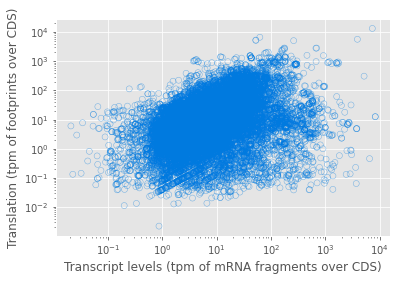

In [23]:
%matplotlib inline
my_figure = plt.figure()
plt.loglog() # log-scaling makes it easier

# make a copy of dataframe for plotting
# this is because 0-values cannot be plotted in log-space,
# so we set them to a pseudo value called `MIN_VAL`

MIN_VAL = np.nan
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_tpm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_tpm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_tpm"],
            plot_df["ribosome_profiling_tpm"],
            marker="o",alpha=0.5,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (tpm of mRNA fragments over CDS)")
plt.ylabel("Translation (tpm of footprints over CDS)")

## Distribution of translation efficiency

In [24]:
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]
df_interest=df_clean[(df_clean["TE_tpm"] >= 5)&(df_clean["TE_tpm"] <= 800)]

(0.0, 100.0)

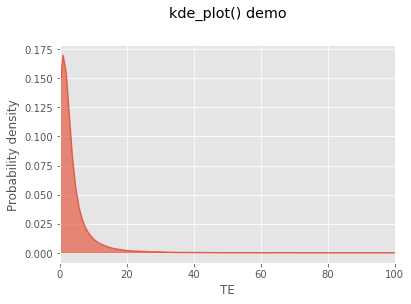

In [30]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_clean["TE_rpkm"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)
plt.xlim(0,100)

Then, we can compare the effects of transcriptional and translational control:

<module 'matplotlib.pyplot' from '/home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/matplotlib/pyplot.py'>

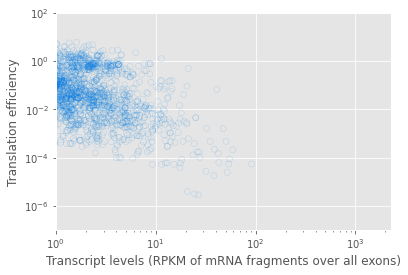

In [56]:
plt.loglog()
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_rpkm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_rpkm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_rpkm"],
            plot_df["TE_tpm"],
            marker="o",alpha=0.2,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (RPKM of mRNA fragments over all exons)")
plt.ylabel("Translation efficiency")
plt.xlim(1,plt.xlim()[1])
plt.ylim(plt.ylim()[0]/10.0,100)

plt

## Creating a table that shows the read counts for transcript. 

In [126]:
df.to_csv(save_path + "FMR1_3_te_table.csv", index=False)